In [ ]:
https://machinelearningmastery.com/sequence-classification-lstm-recurrent-neural-networks-python-keras/

In [1]:
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
#from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
from tensorflow.keras import regularizers

from tensorflow.keras import layers
from tensorflow.keras import losses

from collections import Counter


import pandas as pd
import numpy as np

import sklearn


from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


import seaborn as sns

import pydot



In [2]:
data_train = pd.read_csv('/content/train.csv')
data_train.head()

ID  ... Sub-task B
0  C45.451  ...       NGEN
1   C47.11  ...       NGEN
2   C33.79  ...       NGEN
3  C4.1961  ...       NGEN
4  C10.153  ...       NGEN

[5 rows x 4 columns]

In [3]:

data_test = pd.read_csv('/content/test.csv')


In [4]:
data_train.drop(['ID','Sub-task B'], axis=1, inplace=True)
data_test.drop(['ID','Sub-task B'], axis=1, inplace=True)




In [5]:
NAG_train = data_train[(data_train['Sub-task A']=='NAG')]
OAG_train = data_train[(data_train['Sub-task A']=='CAG')]
CAG_train = data_train[(data_train['Sub-task A']=='OAG')]

In [6]:
NAG_test = data_test[(data_test['Sub-task A']=='NAG')]
OAG_test= data_test[(data_test['Sub-task A']=='CAG')]
CAG_test = data_test[(data_test['Sub-task A']=='OAG')]

In [7]:
import warnings as wrn
wrn.filterwarnings('ignore')

NAG_train["Sub-task A"] = 0 
#negatives_test["Sentiment"] = 0

OAG_train["Sub-task A"] = 1
#positives_test["Sentiment"] = 2

CAG_train["Sub-task A"] = 2
#neutrals_test["Sentiment"] = 1

#NAG_train.head()

In [8]:
import warnings as wrn
wrn.filterwarnings('ignore')

NAG_test["Sub-task A"] = 0 
#negatives_test["Sentiment"] = 0

OAG_test["Sub-task A"] = 1
#positives_test["Sentiment"] = 2

CAG_test["Sub-task A"] = 2
#neutrals_test["Sentiment"] = 1

NAG_test.head()

Text  Sub-task A
0        U deserve more subscribers. U really great.           0
1                                     Nice video....           0
2  sorry if i bother somebody.. iam a defence asp...           0
3  Joker was amazing....it was not glamorised !.....           0
4                                          Nice baro           0

In [9]:
data_train = pd.concat([NAG_train,
                 OAG_train,
                  CAG_train
                ],axis=0)

data_train.reset_index(inplace=True)

In [10]:
data_test = pd.concat([NAG_test,
                  OAG_test,
                  CAG_test
                 ],axis=0)

data_test.reset_index(inplace=True)

In [11]:

data_test = data_test.rename(columns = {'Sub-task A': 'label'}, inplace = False)

In [12]:

data_train = data_train.rename(columns = {'Sub-task A': 'label'}, inplace = False)

In [13]:
data_train

index                                               Text  label
0         0                                          Next part      0
1         1                 Iii8mllllllm\nMdxfvb8o90lplppi0005      0
2         2  🤣🤣😂😂🤣🤣🤣😂osm vedio ....keep it up...make more v...      0
3         3  What the fuck was this? I respect shwetabh and...      0
4         4  Concerned authorities should bring arundathi R...      0
...     ...                                                ...    ...
4258   4238  Personality of a beggar lasts with her/him eve...      2
4259   4245  Ghanta..ek no ek chutiya galti se iski video l...      2
4260   4253           Ban suedo femists and liberals ...F..off      2
4261   4254                                Open bob and vagane      2
4262   4258  Abey loudey Arnab... Did u ever see the vedios...      2

[4263 rows x 3 columns]

In [14]:
data_train.drop(['index'], axis=1, inplace=True)

In [17]:
X = data_train.Text
Y = data_train.label


In [18]:
X_train,X_valid,y_train,y_valid = train_test_split(X,Y,test_size=0.15)

In [19]:

print('Train data len:'+str(len(X_train)))
print('Class distribution'+str(len(y_train)))
print('Valid data len:'+str(len(X_valid)))
print('Class distribution'+ str(len(y_valid)))

Train data len:3623
Class distribution3623
Valid data len:640
Class distribution640


Tokenize the data and convert the text to sequences.
Add padding to ensure that all the sequences have the same shape.
There are many ways of taking the max_len and here an arbitrary length of 150 is chosen.

In [20]:
num_words = 50000

tokenizer = Tokenizer(num_words=num_words,oov_token="unk")
tokenizer.fit_on_texts(X_train)


print(str(tokenizer.texts_to_sequences(['xyz how are you'])))

[[2595, 82, 12, 9]]


In [21]:

x_train = np.array( tokenizer.texts_to_sequences(X_train) )
x_valid = np.array( tokenizer.texts_to_sequences(X_valid) )
x_test  = np.array( tokenizer.texts_to_sequences(data_test['Text'].tolist()) )



x_train = pad_sequences(x_train, padding='post', maxlen=150)
x_valid = pad_sequences(x_valid, padding='post', maxlen=150)
x_test = pad_sequences(x_test, padding='post', maxlen=150)



train_labels = np.asarray(y_train )
valid_labels = np.asarray( y_valid)

test_labels = np.asarray(data_test['label'].tolist())

#print('Train data len:'+str(len(x_train)))
#print('Class distribution'+str(Counter(train_labels)))

#print('Validation data len:'+str(len(x_valid)))
#print('Class distribution'+str(Counter(valid_labels)))

#print('Test data len:'+str(len(x_test)))
#print('Class distribution'+str(Counter(test_labels)))


train_ds = tf.data.Dataset.from_tensor_slices((x_train,train_labels))
valid_ds = tf.data.Dataset.from_tensor_slices((x_valid,valid_labels))
test_ds = tf.data.Dataset.from_tensor_slices((x_test,test_labels))

In [22]:

count =0
print('======Train dataset ====')
for value,label in train_ds:
    count += 1
    print(value,label)
    if count==1:
        break
count =0
print('======Validation dataset ====')
for value,label in valid_ds:
    count += 1
    print(value,label)
    if count==1:
        break
count =0
print('======Test dataset ====')
for value,label in test_ds:
    count += 1
    print(value,label)
    if count==1:
        break

======Train dataset ====
tf.Tensor(
[   8   54 1833    7  603    3    8   98   18    2  892    4   86   94
  129   59   37  287  994   14  108   19  205    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0], shape=(150,), dtype=int32) tf.Tensor(0, shape=(), dtype=int64)
======Validation dataset ====
tf.Tensor(
[192  69   8 170 373  39  11 575   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0

In [23]:

max_features =50000
embedding_dim =16
sequence_length = 150

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(max_features +1, embedding_dim, input_length=sequence_length,\
                                    embeddings_regularizer = regularizers.l2(0.005))) 
model.add(tf.keras.layers.Dropout(0.4))

model.add(tf.keras.layers.LSTM(embedding_dim,dropout=0.2, recurrent_dropout=0.2,return_sequences=True,\
                                                             kernel_regularizer=regularizers.l2(0.005),\
                                                             bias_regularizer=regularizers.l2(0.005)))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(512, activation='relu',\
                                kernel_regularizer=regularizers.l2(0.001),\
                                bias_regularizer=regularizers.l2(0.001),))
model.add(tf.keras.layers.Dropout(0.4))

model.add(tf.keras.layers.Dense(8, activation='relu',\
                                kernel_regularizer=regularizers.l2(0.001),\
                                bias_regularizer=regularizers.l2(0.001),))
model.add(tf.keras.layers.Dropout(0.4))


model.add(tf.keras.layers.Dense(1,activation='sigmoid'))
                               



model.summary()
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),optimizer=tf.keras.optimizers.Adam(1e-3),metrics=[tf.keras.metrics.Accuracy()])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 150, 16)           800016    
_________________________________________________________________
dropout (Dropout)            (None, 150, 16)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 150, 16)           2112      
_________________________________________________________________
flatten (Flatten)            (None, 2400)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1229312   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 4

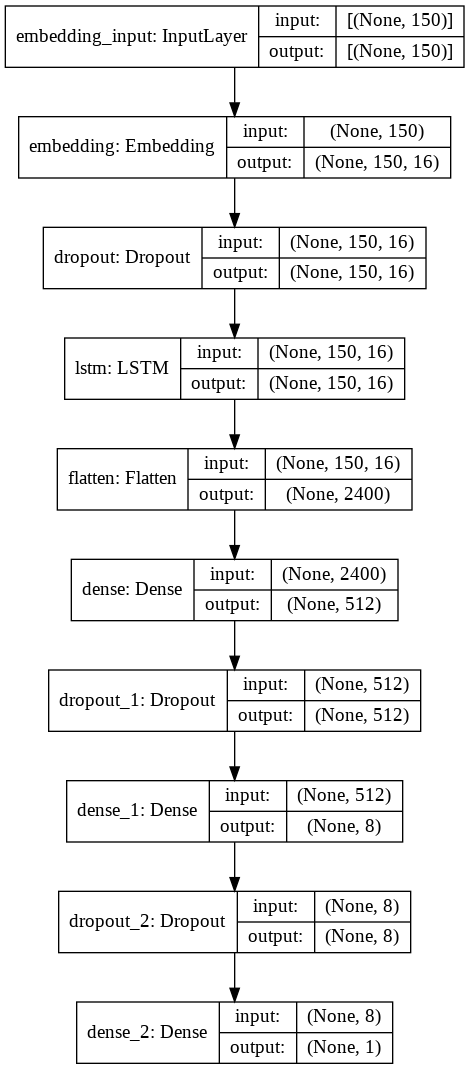

In [24]:

tf.keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

In [25]:
epochs = 30
# Fit the model using the train and test datasets.
#history = model.fit(x_train, train_labels,validation_data= (x_test,test_labels),epochs=epochs )
history = model.fit(train_ds.shuffle(5000).batch(1024),
                    epochs= epochs ,
                    validation_data=valid_ds.batch(1024),
                    verbose=1)

Epoch 1/30
4/4 [==============================] - 8s 972ms/step - loss: 4.1227 - accuracy: 0.0000e+00 - val_loss: 3.5463 - val_accuracy: 0.0000e+00
Epoch 2/30
4/4 [==============================] - 3s 858ms/step - loss: 3.2992 - accuracy: 0.0000e+00 - val_loss: 2.8236 - val_accuracy: 0.0000e+00
Epoch 3/30
4/4 [==============================] - 3s 855ms/step - loss: 2.6245 - accuracy: 0.0000e+00 - val_loss: 2.2458 - val_accuracy: 0.0000e+00
Epoch 4/30
4/4 [==============================] - 3s 822ms/step - loss: 2.0912 - accuracy: 0.0000e+00 - val_loss: 1.8013 - val_accuracy: 0.0000e+00
Epoch 5/30
4/4 [==============================] - 3s 802ms/step - loss: 1.6870 - accuracy: 0.0000e+00 - val_loss: 1.4777 - val_accuracy: 0.0000e+00
Epoch 6/30
4/4 [==============================] - 3s 862ms/step - loss: 1.3997 - accuracy: 0.0000e+00 - val_loss: 1.2623 - val_accuracy: 0.0000e+00
Epoch 7/30
4/4 [==============================] - 3s 807ms/step - loss: 1.2167 - accuracy: 0.0041 - val_loss: 1.

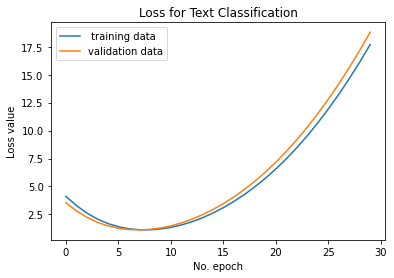

In [26]:
plt.plot(history.history['loss'], label=' training data')
plt.plot(history.history['val_loss'], label='validation data')
plt.title('Loss for Text Classification')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [27]:

x_test  = np.array( tokenizer.texts_to_sequences(data_test['Text'].tolist()) )
x_test = pad_sequences(x_test, padding='post', maxlen=150)


In [28]:
print("Generate predictions for all samples")
predictions = model.predict(x_test)

Generate predictions for all samples


In [29]:

data_test['pred']= predictions

In [30]:

labels = [0,1,2]
    
print(classification_report(data_test['label'].tolist(),data_test['pred'].tolist(),labels=labels))

              precision    recall  f1-score   support

           0       0.78      1.00      0.88       836
           1       0.00      0.00      0.00       117
           2       0.00      0.00      0.00       113

    accuracy                           0.78      1066
   macro avg       0.26      0.33      0.29      1066
weighted avg       0.62      0.78      0.69      1066

